## DEMO AND TUTORIAL FOR LES FURNITURES

### Setting directory

In [1]:
import os
dirmain = os.getcwd()
print(dirmain)

/home/sa11799x/Documents/Test/ScenRec/ScenRec


### Cloning repo

In [2]:
!git clone https://github.com/AryamanSharma17/Grounded-Segment-Anything

fatal: destination path 'Grounded-Segment-Anything' already exists and is not an empty directory.


### Installing Meta files

In [3]:
# dirmain = dir + '/Grounded-Segment-Anything'
os.chdir(dirmain + '/Grounded-Segment-Anything')
%pip install -q -r requirements.txt
os.chdir(dirmain + '/Grounded-Segment-Anything/segment_anything')
%pip install -q .
os.chdir(dirmain + '/Grounded-Segment-Anything/GroundingDINO')
!pip install -q .
os.chdir(dirmain + '/Grounded-Segment-Anything')


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


New directory should be: Main Directory + Grounded-Segment-Anything

In [4]:
os.getcwd()

'/home/sa11799x/Documents/Test/ScenRec/ScenRec/Grounded-Segment-Anything'

In [5]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import csv
import pandas as pd


from huggingface_hub import hf_hub_download

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    args.device = device
    model = build_model(args)
    
    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

Grounding DINO

In [8]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device='cuda')

/home/sa11799x/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /home/sa11799x/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


SAM

In [9]:
if os.path.exists(dirmain+'/Grounded-Segment-Anything/sam_vit_b_01ec64.pth')==False:
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
sam_checkpoint = 'sam_vit_b_01ec64.pth'
sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))


LOAD IMAGE

In [10]:
test_image = dirmain +'/Resource/classroom_simple.jpg'
image_source, image = load_image(test_image)
source_image = Image.fromarray(image_source)

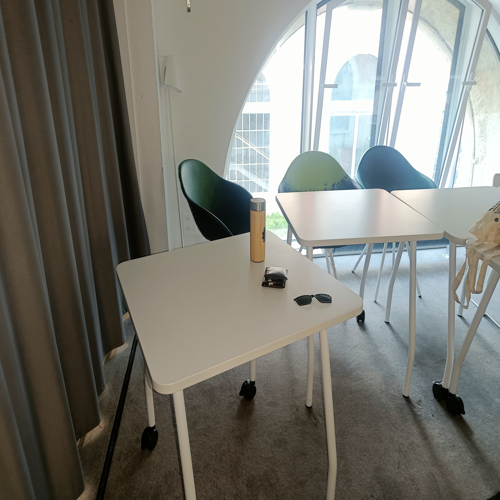

In [11]:
source_image = source_image.resize((500,500))
image_source = np.asarray(source_image)
Image.fromarray(image_source)

In [12]:
image_source.shape

(500, 500, 3)

Bounding box and center generation with GDINO

In [13]:
def detect(image, text_prompt, model, box_threshold = 0.4, text_threshold = 0.2):
  boxes, logits, phrases = predict(
      model=model, 
      image=image, 
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB 
  return annotated_frame, boxes,phrases, logits


def gen_mask_Gd(image_source, boxes):
    h,w,_ = image_source.shape
    boxes_unnorm = boxes * torch.Tensor([w,h,w,h]) 
    boxes_xyxy = box_convert(boxes =boxes_unnorm, in_fmt = "cxcywh", out_fmt = "xyxy").numpy()
    mask = np.zeros_like(image_source)
    for box in boxes_xyxy:
        x0, y0,x1,y1 = box
        mask[int(y0):int(y1), int(x0):int(x1),:] = 255
    return mask, boxes_xyxy, boxes_unnorm

def center(centerx,centery,detected_boxes):
    for i in range(len(detected_boxes)):
        centerx.append(int(detected_boxes[i][0] + detected_boxes[i][2])/2)
        centery.append(int(detected_boxes[i][1] + detected_boxes[i][3])/2)
    return centerx,centery

In [14]:
annotated_frame, detected_boxes,phrases, logits = detect(image, text_prompt="chair. table. sofa. door. window", model=groundingdino_model, box_threshold=0.5 )
anoim = Image.fromarray(annotated_frame)

/home/sa11799x/anaconda3/lib/python3.9/site-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/sa11799x/anaconda3/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
2023-06-05 13:50:56.091806: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 13:50:58.481521: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
mask,box_change,box_unnormalized = gen_mask_Gd(image_source,detected_boxes)

In [16]:
centerx = []
centery = []

centerx,centery = center(centerx,centery,box_change)

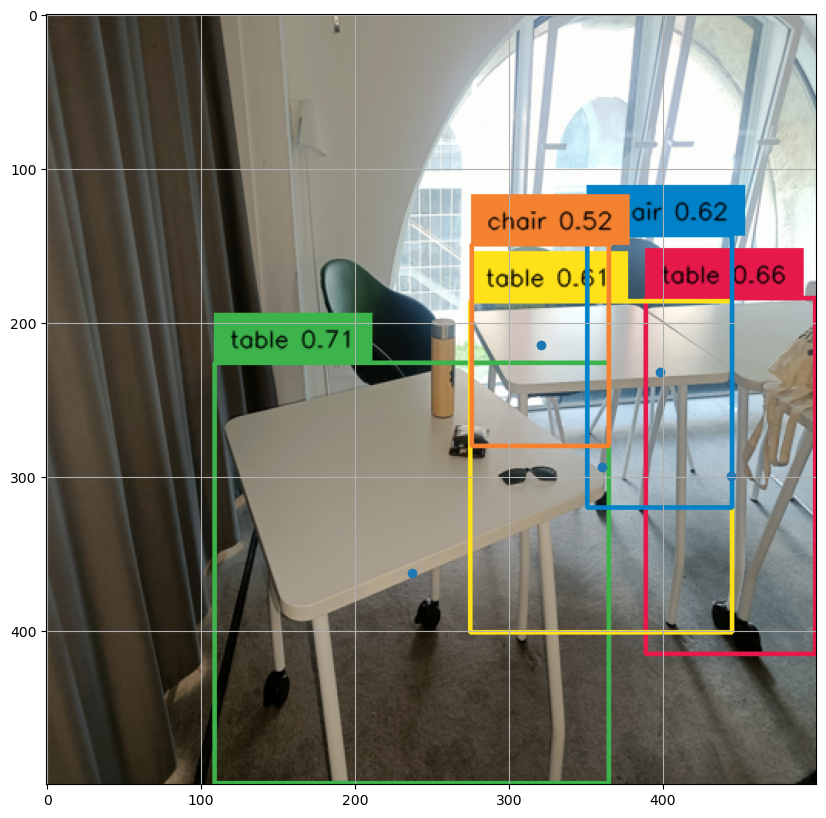

In [17]:
import matplotlib.pyplot as plt
c = np.array(["red","green","yellow","cyan","orange", "lime", "pink","Maroon", "purple", "aquamarine", "olive", "khakhi"])

plt.figure(figsize=(10,10))
scatter = plt.scatter(centerx,centery )
plt.imshow(anoim)
plt.grid()

SAM: Segmentation

In [18]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cuda()
  

def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.cpu().reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

Single Mask Creation

In [19]:
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)


Multiple Mask fusion

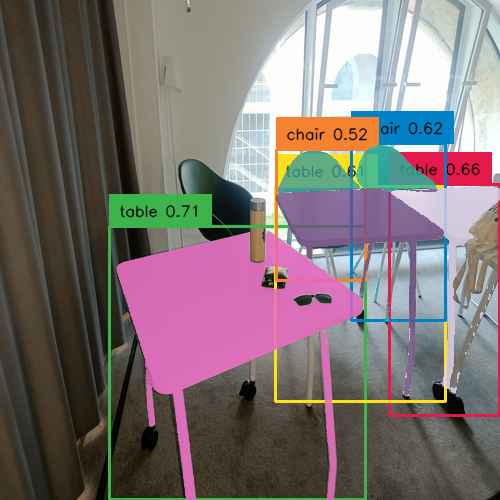

In [20]:
all_frames = annotated_frame
for i in range(len(segmented_frame_masks)):
  all_frames = draw_mask(segmented_frame_masks[i][0], all_frames)
Image.fromarray(all_frames)

In [21]:
allmask = segmented_frame_masks[0][0].cpu().numpy()
for i in range(1,len(segmented_frame_masks)):
    allmask += segmented_frame_masks[i][0].cpu().numpy() 

In [22]:
allmask_image = Image.fromarray(allmask)


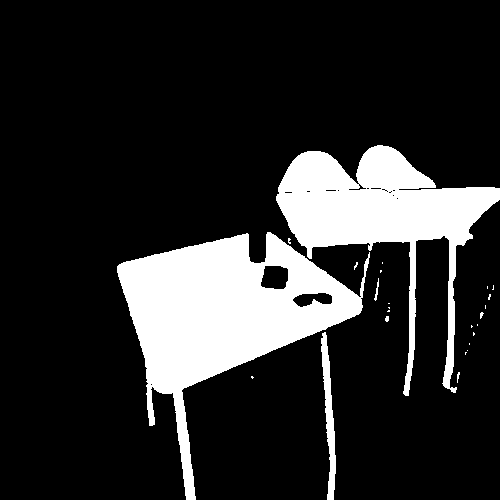

In [23]:
display(allmask_image)

Preprocessing the image to invert the axes

In [24]:
# allmask_image=allmask_image.rotate(180)
y_main = np.where(allmask==1)[0]
x_main = np.where(allmask==1)[1]

In [25]:
int_all_mask = np.array(allmask_image, dtype=np.uint8)

### EROSION

In [26]:
kernel = np.ones((4,4),np.uint8)
erosion = cv2.erode(int_all_mask, kernel, iterations=1)

In [27]:
y_erode = np.where(erosion==1)[0]
x_erode = np.where(erosion==1)[1]


Eroded Image

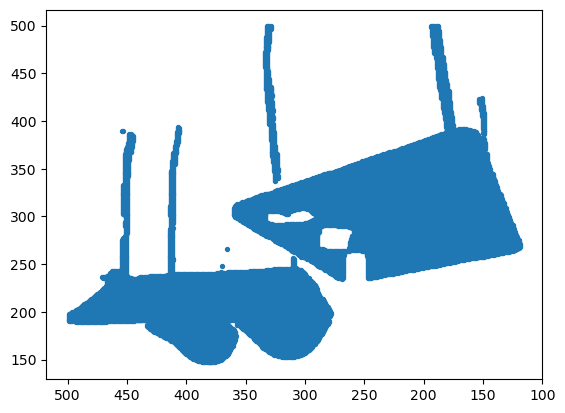

In [28]:
plt.scatter(x_erode,y_erode, 8)
plt.gca().invert_xaxis()

Actual Image

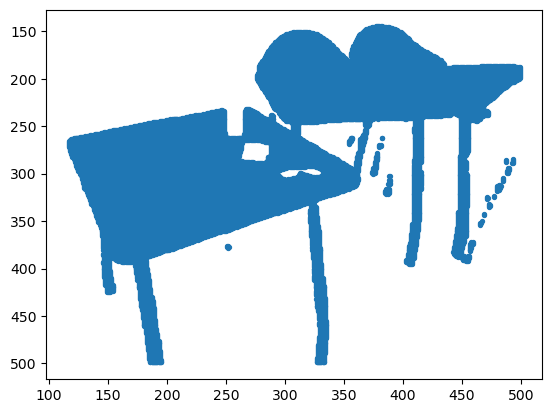

In [29]:
plt.scatter(x_main,y_main, 8)
plt.gca().invert_yaxis()

In [30]:
depth = np.zeros(len(phrases))

Creating output file for VR

In [31]:
data = np.empty((len(phrases),9),dtype=object)
data.fill([])

In [38]:
for i in range(len(phrases)):
    for j in range(4):
        data[i][j] = (box_change[i][j])
    data[i][4] = centerx[i]
    data[i][5] = centery[i]
    data[i][6] = depth[i]
    data[i][7] = (phrases[i])
    data[i][8] = logits[i].item()

Rectangles : ABCD

A = 0, 1

B = 0, 3

C = 2, 3

D = 2, 1

center = 4, 5

depth centner = 6

furniture type = 7

In [39]:
df = pd.DataFrame(data=data, columns=['Coord 1','Coord 2','Coord 3','Coord 4','Center_X', 'Center_Y', 'Depth', 'Furniture category', 'Confidence'])
df

,Coord 1,Coord 2,Coord 3,Coord 4,Center_X,Center_Y,Depth,Furniture category,Confidence
0,389.077698,184.017624,499.790771,415.018372,444.0,299.5,0.0,table,0.658162
1,109.349747,226.253723,365.327454,499.020691,237.0,362.5,0.0,table,0.706893
2,275.019409,186.024109,445.72644,401.694702,360.0,293.5,0.0,table,0.61198
3,351.419861,143.936737,445.303223,320.107422,398.0,232.0,0.0,chair,0.619808
4,276.465393,149.471481,365.918823,280.080933,321.0,214.5,0.0,chair,0.518841


In [34]:
os.chdir(dirmain)

In [35]:
df.to_csv('Vr.csv')

### DEPTH ESTIMATION